In [ ]:
input_file = 'data/simple_user_log.jsonlines'
output_file = 'data/output/simple_user_log.jsonlines'

In [ ]:
import logging
import typing

from IPython.display import Image
import cudf

from morpheus.config import Config

from morpheus.pipeline import Pipeline
from morpheus.pipeline.execution_mode_mixins import GpuAndCpuMixin
from morpheus.pipeline.pass_thru_type_mixin import PassThruTypeMixin
from morpheus.pipeline.single_port_stage import SinglePortStage

from morpheus.pipeline.stage import Stage
from morpheus.pipeline.stage_schema import StageSchema

from morpheus.stages.input.file_source_stage import FileSourceStage
from morpheus.stages.output.in_memory_sink_stage import InMemorySinkStage
from morpheus.stages.output.write_to_file_stage import WriteToFileStage

from morpheus.messages import MessageMeta

from morpheus.utils.logger import configure_logging, reset_logging

import mrc
import mrc.core.operators as ops
from mrc.core.node import Broadcast

In [ ]:
class MpBroadcastStage(GpuAndCpuMixin, Stage):

    def __init__(self, c: Config):
        super().__init__(c)

        self._create_ports(1, 3) # One input port, two output ports.

    @property
    def name(self) -> str:
        return "mp-bcast"

    def supports_cpp_node(self):
        return False
    
    def accepted_types(self) -> tuple:
        return (MessageMeta, )
    
    def compute_schema(self, schema: StageSchema):
        for port_schema in schema.output_schemas:
            port_schema.set_type(MessageMeta)
    
    def on_data(self, message: MessageMeta) -> MessageMeta:
        return message

    def _build(self, builder: mrc.Builder, input_nodes: list[mrc.SegmentObject]) -> list[mrc.SegmentObject]:

        # Create a broadcast node
        broadcast = Broadcast(builder, "broadcast")
        builder.make_edge(input_nodes[0], broadcast)

        # Here we create 3 outgoing nodes.
        outgoing_1 = builder.make_node("outgoing_1", ops.map(self.on_data))
        outgoing_2 = builder.make_node("outgoing_2", ops.map(self.on_data))
        outgoing_3 = builder.make_node("outgoing_3", ops.map(self.on_data))
        
        # Here we create edges between the broadcast node and each of the outgoing nodes.
        builder.make_edge(broadcast, outgoing_1)
        builder.make_edge(broadcast, outgoing_2)
        builder.make_edge(broadcast, outgoing_3)

        # Here we return all three outgoing nodes.
        return [outgoing_1, outgoing_2, outgoing_3]

In [ ]:
config = Config()
pipeline = Pipeline(config)

source = pipeline.add_stage(FileSourceStage(config, filename=input_file, iterative=False))
broadcast = pipeline.add_stage(MpBroadcastStage(config))
pipeline.add_edge(source, broadcast)

in_mem_sink_1 = pipeline.add_stage(InMemorySinkStage(config))
in_mem_sink_2 = pipeline.add_stage(InMemorySinkStage(config))
write_to_file = pipeline.add_stage(WriteToFileStage(config, filename=output_file, overwrite=True))


pipeline.add_edge(broadcast.output_ports[0], in_mem_sink_1)
pipeline.add_edge(broadcast.output_ports[1], in_mem_sink_2)
pipeline.add_edge(broadcast.output_ports[2], write_to_file)

In [ ]:
pipeline.build()

In [ ]:
viz_file = './pipeline_visualizations/broadcast_three_way_passthrough.png'
pipeline.visualize(viz_file)

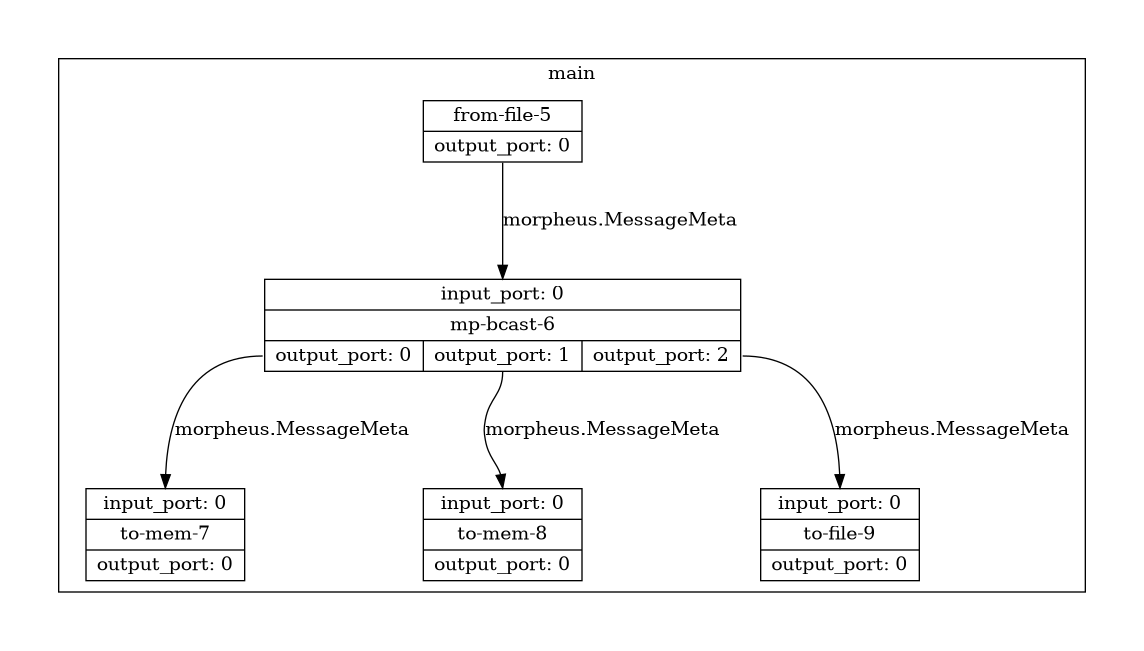

In [ ]:
Image(filename=viz_file)

In [ ]:
reset_logging()
configure_logging(log_level=logging.DEBUG)

W20251023 08:25:48.313946 140426084280128 logging.cpp:67] MRC logger already initialized


====Starting Pipeline====
====Building Segment: main====
Added source: <from-file-5; FileSourceStage(filename=data/simple_user_log.jsonlines, iterative=False, file_type=FileTypes.Auto, repeat=1, filter_null=True, filter_null_columns=None, parser_kwargs=None)>
  └─> morpheus.MessageMeta
Added stage: <to-mem-7; InMemorySinkStage()>
  └─ morpheus.MessageMeta -> morpheus.MessageMeta
Added stage: <to-mem-8; InMemorySinkStage()>
  └─ morpheus.MessageMeta -> morpheus.MessageMeta
Added stage: <to-file-9; WriteToFileStage(filename=data/output/simple_user_log.jsonlines, overwrite=True, file_type=FileTypes.Auto, include_index_col=True, flush=False)>
  └─ morpheus.MessageMeta -> morpheus.MessageMeta
====Pipeline Started====
====Building Segment Complete!====
====Pipeline Complete====


In [ ]:
await pipeline.run_async()

Since we created two output memory sink stages, let's observe them both.

In [ ]:
messages = in_mem_sink_1.get_messages()
messages[0].df

,timestamp,user,ip_address,request_time,status,error_message
0,2025-02-01T10:15:30Z,user123,192.168.1.10,200.45,success,<NA>
1,2025-02-01T10:17:00Z,user123,192.168.1.20,150.55,failure,Invalid credentials
2,2025-02-01T10:18:10Z,user456,10.0.0.5,180.60,success,<NA>
3,2025-02-01T10:19:25Z,user789,192.168.1.30,215.25,failure,Timeout
4,2025-02-01T10:20:00Z,user456,10.0.0.6,120.10,success,<NA>
5,2025-02-01T10:22:30Z,user123,192.168.1.40,175.35,failure,Access denied
6,2025-02-01T10:23:45Z,user321,192.168.1.50,205.50,success,<NA>
7,2025-02-01T10:25:05Z,user864,192.168.1.60,190.15,failure,Invalid session
8,2025-02-01T10:26:20Z,user123,192.168.1.70,210.80,success,<NA>
9,2025-02-01T10:27:40Z,user456,10.0.0.7,160.95,failure,Account locked


In [ ]:
messages = in_mem_sink_2.get_messages()
messages[0].df

,timestamp,user,ip_address,request_time,status,error_message
0,2025-02-01T10:15:30Z,user123,192.168.1.10,200.45,success,<NA>
1,2025-02-01T10:17:00Z,user123,192.168.1.20,150.55,failure,Invalid credentials
2,2025-02-01T10:18:10Z,user456,10.0.0.5,180.60,success,<NA>
3,2025-02-01T10:19:25Z,user789,192.168.1.30,215.25,failure,Timeout
4,2025-02-01T10:20:00Z,user456,10.0.0.6,120.10,success,<NA>
5,2025-02-01T10:22:30Z,user123,192.168.1.40,175.35,failure,Access denied
6,2025-02-01T10:23:45Z,user321,192.168.1.50,205.50,success,<NA>
7,2025-02-01T10:25:05Z,user864,192.168.1.60,190.15,failure,Invalid session
8,2025-02-01T10:26:20Z,user123,192.168.1.70,210.80,success,<NA>
9,2025-02-01T10:27:40Z,user456,10.0.0.7,160.95,failure,Account locked


In [ ]:
cudf.read_json(output_file, lines=True)

,timestamp,user,ip_address,request_time,status,error_message
0,2025-02-01T10:15:30Z,user123,192.168.1.10,200.45,success,<NA>
1,2025-02-01T10:17:00Z,user123,192.168.1.20,150.55,failure,Invalid credentials
2,2025-02-01T10:18:10Z,user456,10.0.0.5,180.60,success,<NA>
3,2025-02-01T10:19:25Z,user789,192.168.1.30,215.25,failure,Timeout
4,2025-02-01T10:20:00Z,user456,10.0.0.6,120.10,success,<NA>
5,2025-02-01T10:22:30Z,user123,192.168.1.40,175.35,failure,Access denied
6,2025-02-01T10:23:45Z,user321,192.168.1.50,205.50,success,<NA>
7,2025-02-01T10:25:05Z,user864,192.168.1.60,190.15,failure,Invalid session
8,2025-02-01T10:26:20Z,user123,192.168.1.70,210.80,success,<NA>
9,2025-02-01T10:27:40Z,user456,10.0.0.7,160.95,failure,Account locked
